In [1]:
import numpy as np
import scipy as sp
from scipy import misc, stats
import pandas as pd
from PIL import Image
import matplotlib.pyplot as plt
import seaborn as sns
from pandas import DataFrame, Series
import warnings
warnings.filterwarnings('ignore')



In [2]:
MAIN_TAG = '2007'
DIRNAME_TAGS = 'MIRFlickr25k_tags/tags/'
DIRNAME_IMAGES = 'mirflickr/'

COLOR = {'RED': 0,
         'GREEN': 1,
         'BLUE': 2}

In [3]:
from os import listdir
from matplotlib import image
import random
np.random.RandomState(4)
random_indexes = np.random.choice(range(25000), 250)
loaded_images = list()
image_names = list()
for i in range(250):
	randName = random_indexes[i]
	image_names.append(randName)
	filename = 'im' + str(randName) + '.jpg'
	img_data = image.imread('mirflickr/' + filename)
	loaded_images.append(img_data)


In [4]:
len(image_names)


250

In [5]:
import codecs
import os

Y = pd.Series()
for name in image_names:
    with codecs.open(os.path.join(DIRNAME_TAGS, 'tags%d.txt' % (name,)), "r", "utf_8_sig") as file:
        set_tags = set(tag.strip() for tag in file.readlines())
        Y.at[name] = int(MAIN_TAG in set_tags)
Y = pd.DataFrame(Y, columns=['target'])

In [6]:
Y['target'].value_counts()

0    241
1      8
Name: target, dtype: int64

In [7]:
Y.head()

,target
12685,0
10086,0
16782,0
14369,0
15757,0


In [21]:
#STATIC DATA

data_static = DataFrame()
num = 0
d = []
for image_name in image_names:
    image = np.array(Image.open(os.path.join(DIRNAME_IMAGES, 'im%d.jpg' % (image_name))))
    data = []
    for name, num in COLOR.items():
        a = image[:, :, num].ravel()
        data.extend([np.mean(a), np.var(a), sp.stats.skew(a), sp.stats.kurtosis(a)])
    d.append([image_name, *data])
    

data_static = pd.DataFrame.from_records(d)
data_static = data_static.rename(columns={0: 'name'}).set_index('name')

In [22]:
data_static.head()

,1,2,3,4,5,6,7,8,9,10,11,12
name,,,,,,,,,,,,
12685,73.802808,9175.108586,0.705485,-1.330825,57.543174,4945.143438,0.878022,-0.812728,16.003837,911.013148,2.073557,3.705262
10086,130.826384,5242.890200,0.100432,-1.319348,102.532234,3629.409526,0.354705,-0.884836,63.960198,2600.628764,0.999925,0.436045
16782,130.230245,5075.098566,-0.006369,-1.462990,105.027525,1661.014992,0.626722,0.965418,62.872752,1180.766107,0.927394,3.520996
14369,113.082438,4367.585636,0.563258,-0.772476,110.789808,4068.123201,0.525437,-0.659390,112.444631,4180.284496,0.554359,-0.649634
15757,121.189129,7459.811654,-0.186845,-1.528438,109.473754,6394.108074,-0.036436,-1.409435,71.637970,5720.422027,0.712548,-0.754696


In [10]:
data_static.shape

(250, 12)

In [23]:
#Learning

import itertools
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.svm import SVC
from sklearn.model_selection import KFold, cross_val_score, train_test_split
from sklearn.metrics import accuracy_score, recall_score, confusion_matrix

In [24]:
N = 12

In [25]:
def plot_confusion_matrix(cm, classes,
                          normalize=True,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
 
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, round(cm[i, j], 3),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

font = {'size' : 15}

plt.rc('font', **font)

In [26]:
#STATIC

X = data_static.copy()

df = Y.join(X, how='inner')
df = df.drop_duplicates()

y = df['target']
X = df.drop('target', axis=1)

Normalized confusion matrix
[[0.98761184 0.01238816]
 [0.9787234  0.0212766 ]]


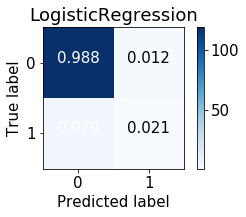

Normalized confusion matrix
[[0. 1.]
 [0. 1.]]


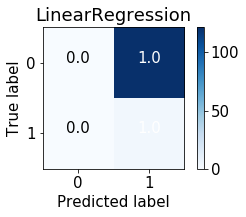

Normalized confusion matrix
[[1. 0.]
 [1. 0.]]


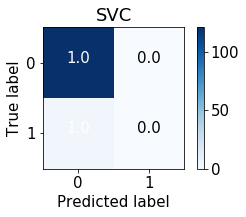

In [27]:
for c in (LogisticRegression, LinearRegression, SVC):
    cls = c()
    cnf_matrix = []
    for i in range(N):
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.5)
        cls.fit(X_train, y_train)
        y_predict = cls.predict(X_test)
        cnf_matrix.append(confusion_matrix(y_test, y_predict.astype(bool).astype(int)))
    cnf_matrix = np.mean(np.array(cnf_matrix), axis=0)
    plt.figure(figsize=(4, 3))
    plot_confusion_matrix(cnf_matrix, classes=['0', '1'],
                          title=c.__name__)
    plt.savefig("static_" + c.__name__ + ".png")
    plt.show()

Normalized confusion matrix
[[0.99378882 0.00621118]
 [1.         0.        ]]


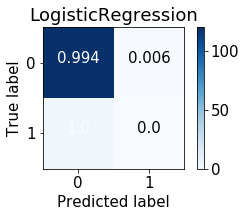

[[120.     0.75]
 [  4.25   0.  ]]
Normalized confusion matrix
[[0.99519561 0.00480439]
 [1.         0.        ]]


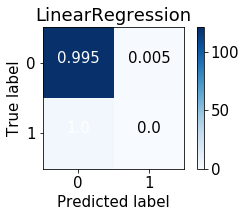

[[120.83333333   0.58333333]
 [  3.58333333   0.        ]]
Normalized confusion matrix
[[0.99448656 0.00551344]
 [1.         0.        ]]


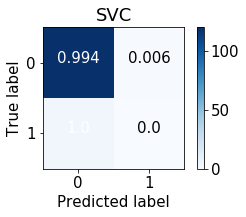

[[120.25         0.66666667]
 [  4.08333333   0.        ]]


In [28]:
#SPAM
for c in (LogisticRegression, LinearRegression, SVC):
    cls = LinearRegression(n_jobs=-1)
    cnf_matrix = []
    for i in range(N):
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.5)
        cls.fit(X_train, y_train)
        y_predict = cls.predict(X_test).astype(int)
   
        cnf_matrix.append(confusion_matrix(y_test, y_predict.astype(bool).astype(int))) # .astype(int)
    cnf_matrix = np.mean(np.array(cnf_matrix), axis=0)
    plt.figure(figsize=(4, 3))
    plot_confusion_matrix(cnf_matrix, classes=['0', '1'],
                              title=c.__name__)
    plt.savefig("spam" + c.__name__ + ".png")
    plt.show()
    print(cnf_matrix)

Normalized confusion matrix
[[0.9869146  0.0130854 ]
 [0.91666667 0.08333333]]


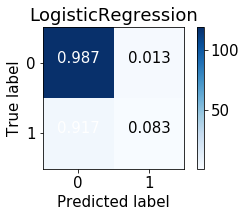

Normalized confusion matrix
[[0. 1.]
 [0. 1.]]


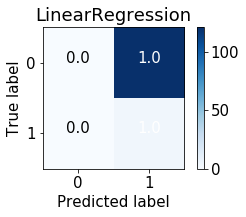

Normalized confusion matrix
[[1. 0.]
 [1. 0.]]


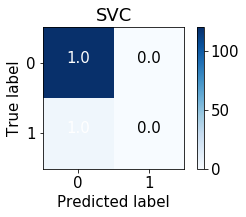

In [29]:
#CCPEV
for c in (LogisticRegression, LinearRegression, SVC):
    cnf_matrix = []
    for i in range(N):
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.5)
        cls = c()
        cls.fit(X_train, y_train)
        y_predict = cls.predict(X_test)
        cnf_matrix.append(confusion_matrix(y_test, y_predict.astype(bool).astype(int)))
    cnf_matrix = np.mean(np.array(cnf_matrix), axis=0)
    plt.figure(figsize=(4, 3))
    plot_confusion_matrix(cnf_matrix, classes=['0', '1'],
                              title=c.__name__)
    plt.savefig("ccpev_" + c.__name__ + ".png")
    plt.show()